In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
from src import data
from scipy.stats import spearmanr, rankdata

from netneurotools import metrics # zjistit, proč tohle nefunguje přes pip 
# (mám to stažené lokálně z Githubu a to pak funguje)

import h5py

from nilearn import plotting

# https://neuraldatascience.io/7-eeg/mne_data.html
%matplotlib widget

PLOT=True
plt.rcParams['figure.figsize'] = [10, 10]

!date -I

2024-02-05


/tmp/ipykernel_40640/1331960015.py:5: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(SC))


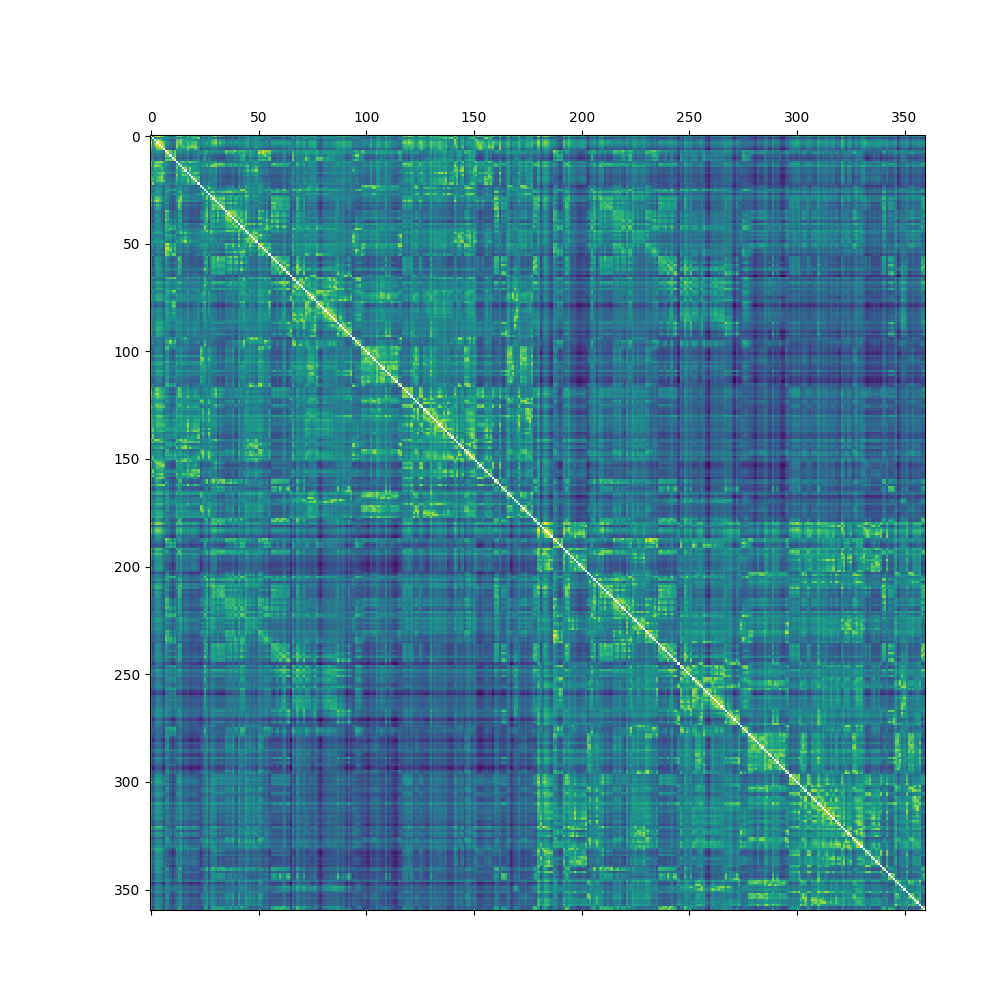

In [2]:
path_sc = '../data/external/rosen_halgren_sc/public_PLoSBio_final/averageConnectivity_axonCount.mat'
with h5py.File(path_sc, 'r') as f:
    SC = np.array(f.get('axonCount'))

plt.matshow(np.log(SC))

In [4]:

path_sc_l = '../data/external/rosen_halgren_sc/public_PLoSBio_final/individualConnectivity_tractLength.mat'

with h5py.File(path_sc_l, 'r') as f:
    print(f.keys())
    #SC_L = np.array(f.get('rawTractLengths'))

#plt.matshow(np.log(SC_L))

<KeysViewHDF5 ['#refs#', 'parcelIDs', 'rawTractLengths', 'subjectIDs', 'tractLengthUnit']>


(array([1.2762e+05, 1.2240e+03, 4.8200e+02, 1.5800e+02, 6.6000e+01,
        1.2000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.4000e+01,
        1.2000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([       0.        ,   616273.20710739,  1232546.41421477,
         1848819.62132216,  2465092.82842954,  3081366.03553693,
         3697639.24264432,  4313912.4497517 ,  4930185.65685909,
         5546458.86396647,  6162732.07107386,  6779005.27818124,
         7395278.48528863,  8011551.69239602,  8627824.8995034 ,
         9244098.10661079,  9860371.31371817, 10476644.52082556,
        11092917.72793294, 11709190.93504033, 12325464.14214772,
        12941737.3492551 , 13558010.55636249, 14174283.76346987,
        14790556.97057726, 15406830.17768465, 16023103.38479203,
     

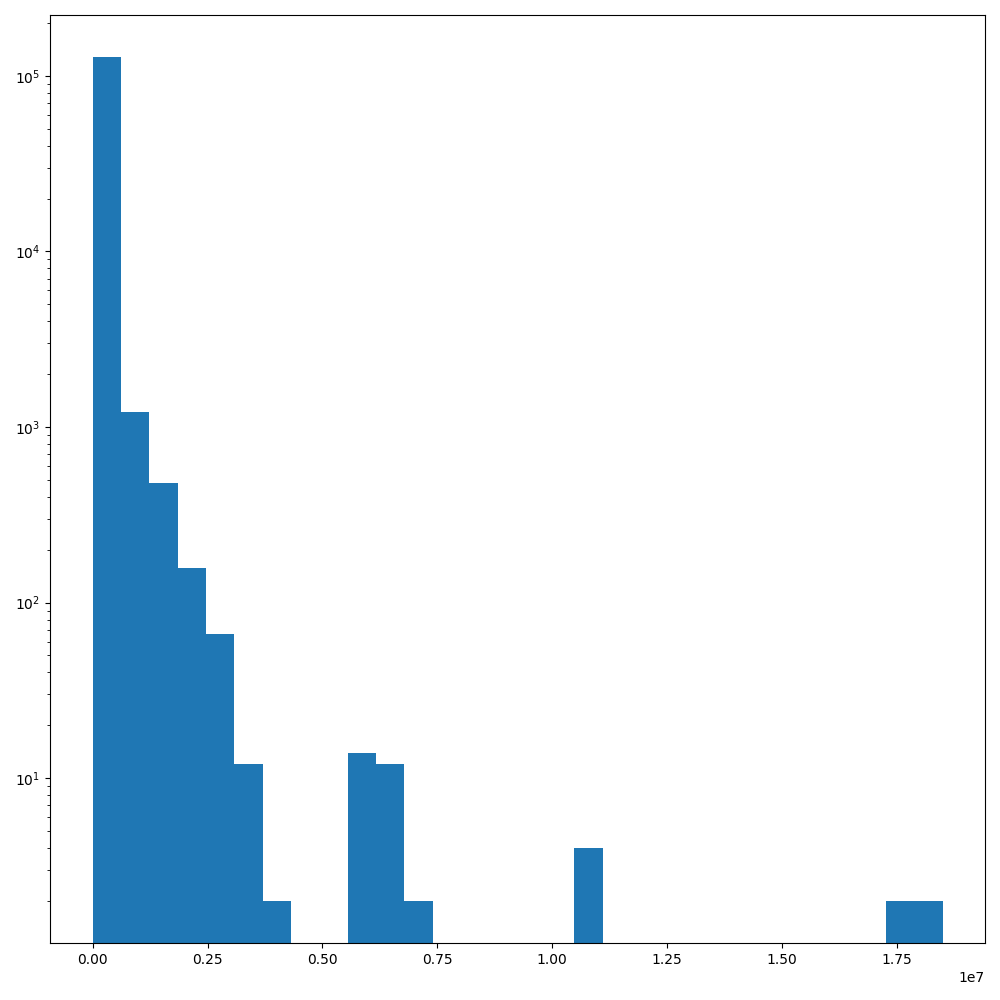

In [53]:
n_bins = 30

# Generate two normal distributions
fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs.hist(SC.flatten(), bins=n_bins,log=True)

In [54]:
rosen_labels = np.loadtxt('../data/external/rosen_halgren_sc/public_PLoSBio_final/roi.txt', dtype=str)

In [55]:
# load data F-TRACT
parcellation = "MNI-HCP-MMP1" 

response_probability = np.loadtxt(f'../data/external/F-TRACT/{parcellation}/probability.txt.gz')
response_amplitude = np.loadtxt(f'../data/external/F-TRACT/{parcellation}/amplitude__median.txt.gz')

print(response_probability.shape)

(360, 360)


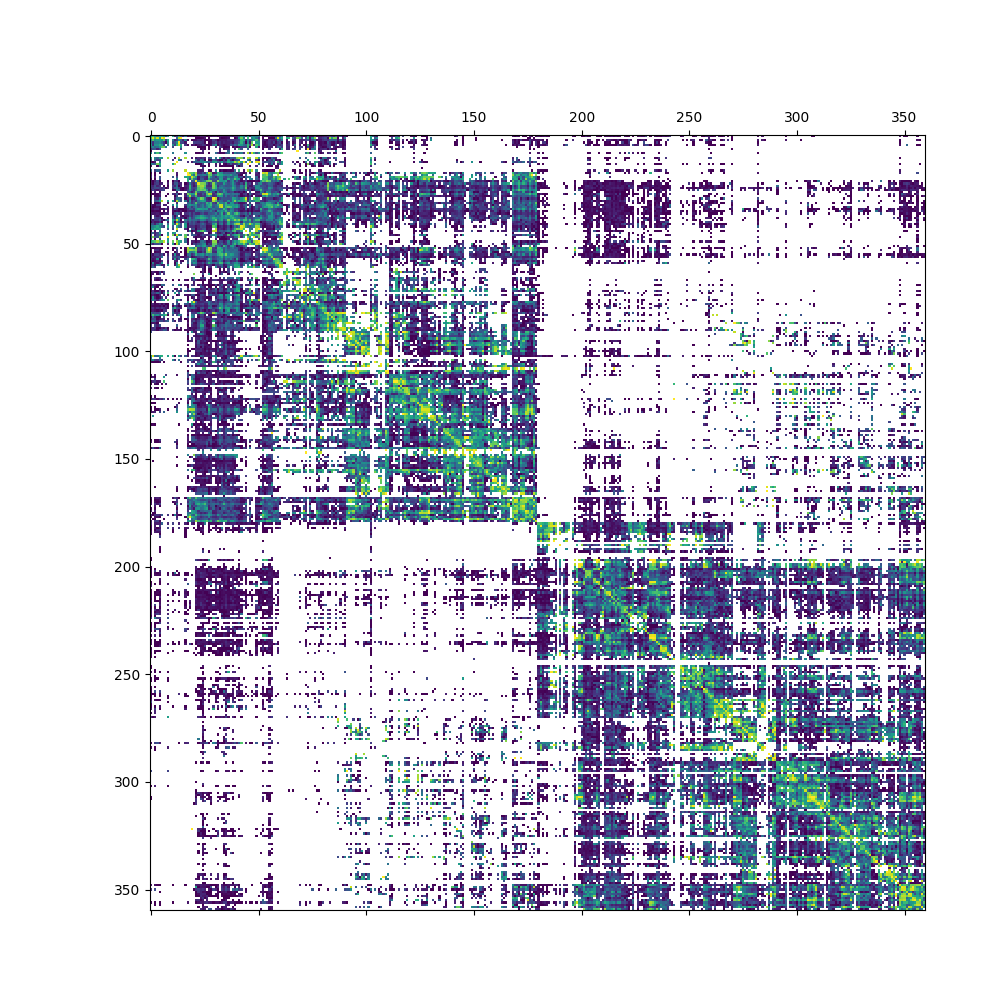

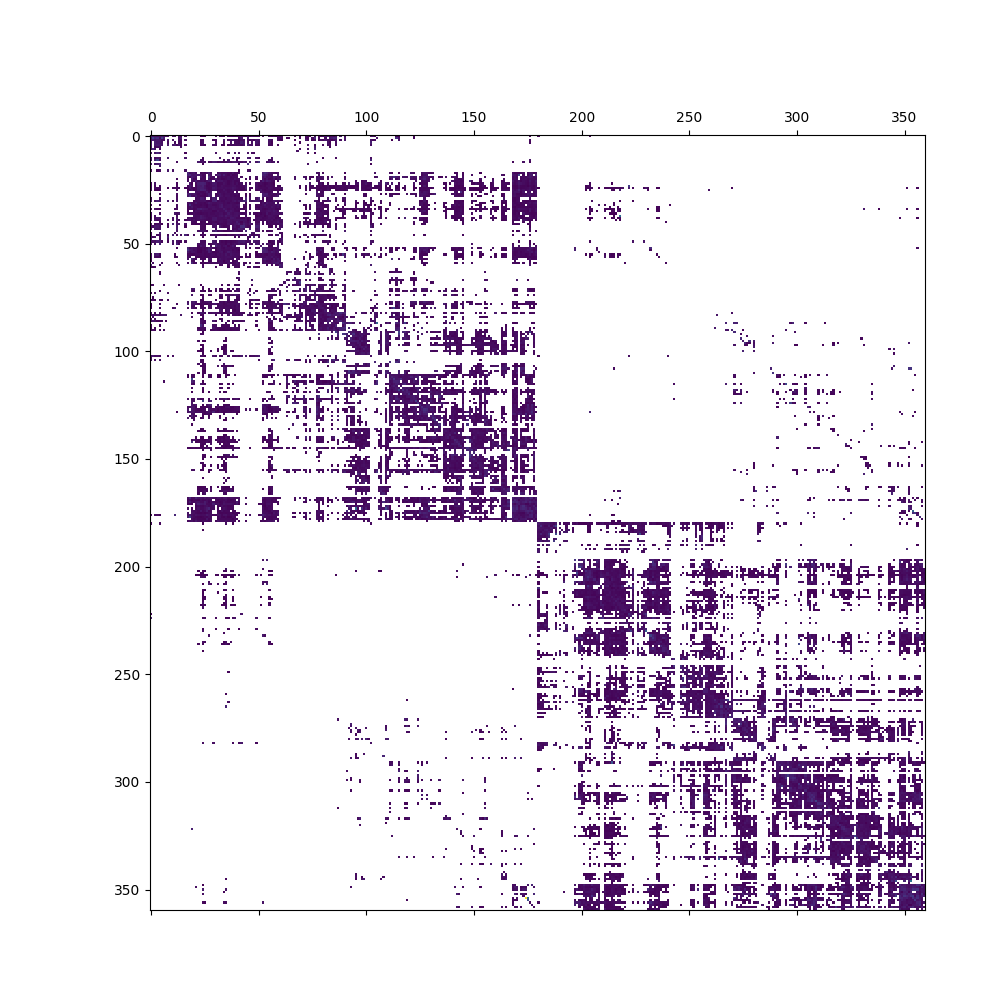

In [56]:
plt.matshow(response_probability)
plt.matshow(response_amplitude)

In [57]:
ftract_labels = np.loadtxt(f'../data/external/F-TRACT/{parcellation}/MNI-HCP-MMP1.txt', dtype=str)

print(rosen_labels[:10])
print(ftract_labels[:10])

['L_V1' 'L_MST' 'L_V6' 'L_V2' 'L_V3' 'L_V4' 'L_V8' 'L_4' 'L_3b' 'L_FEF']
['L_V1' 'L_V6' 'L_V2' 'L_V3' 'L_V4' 'L_V3A' 'L_V7' 'L_IPS1' 'L_V3B'
 'L_V6A']


In [58]:
set(ftract_labels) == set(rosen_labels)

True

/tmp/ipykernel_15116/3570794604.py:5: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(SC_correct))


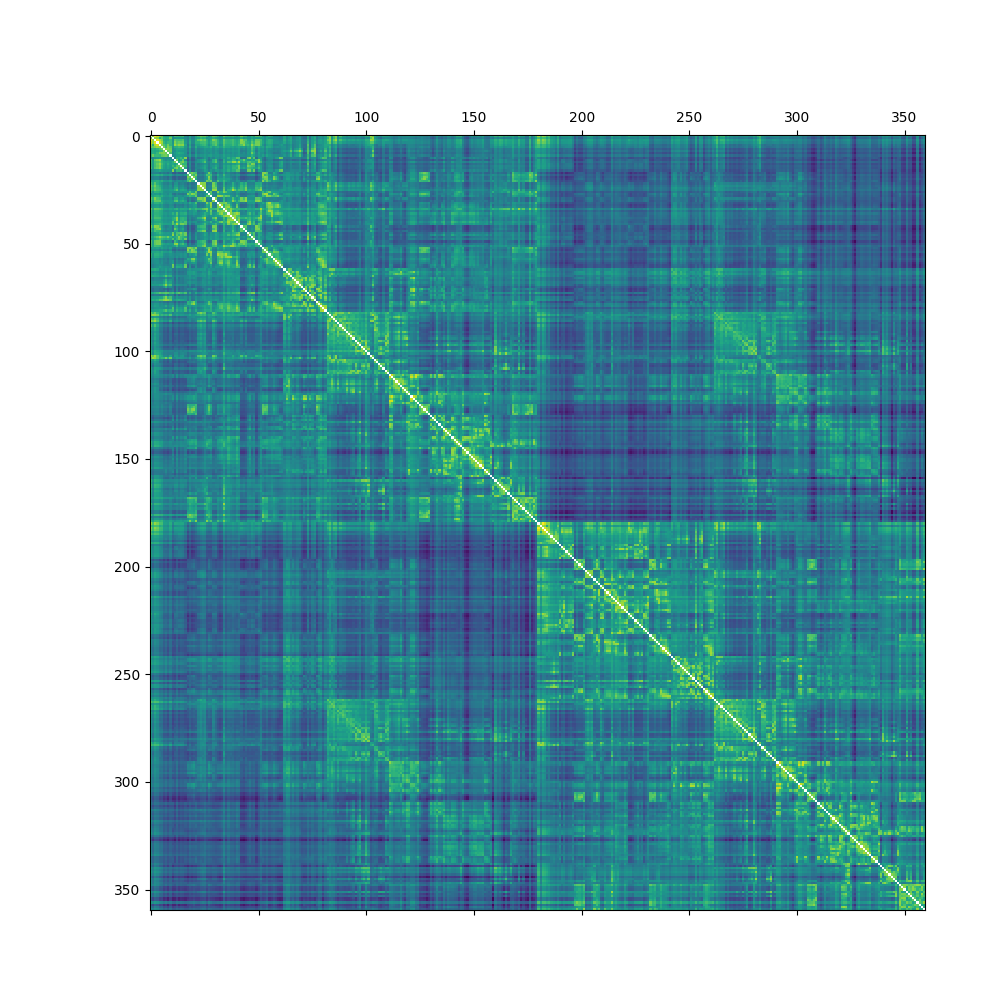

In [59]:
df_SC =  pd.DataFrame(SC, index=rosen_labels, columns=rosen_labels)
df_SC = df_SC.loc[ftract_labels,ftract_labels]

SC_correct = df_SC.to_numpy()
plt.matshow(np.log(SC_correct))

In [60]:
W = SC_correct
L = np.where(SC_correct==0.0,0,1/SC_correct)

/tmp/ipykernel_15116/824288019.py:2: RuntimeWarning: divide by zero encountered in divide
  L = np.where(SC_correct==0.0,0,1/SC_correct)


/tmp/ipykernel_15116/4093769048.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.matshow(n_stim>100, interpolation='none')


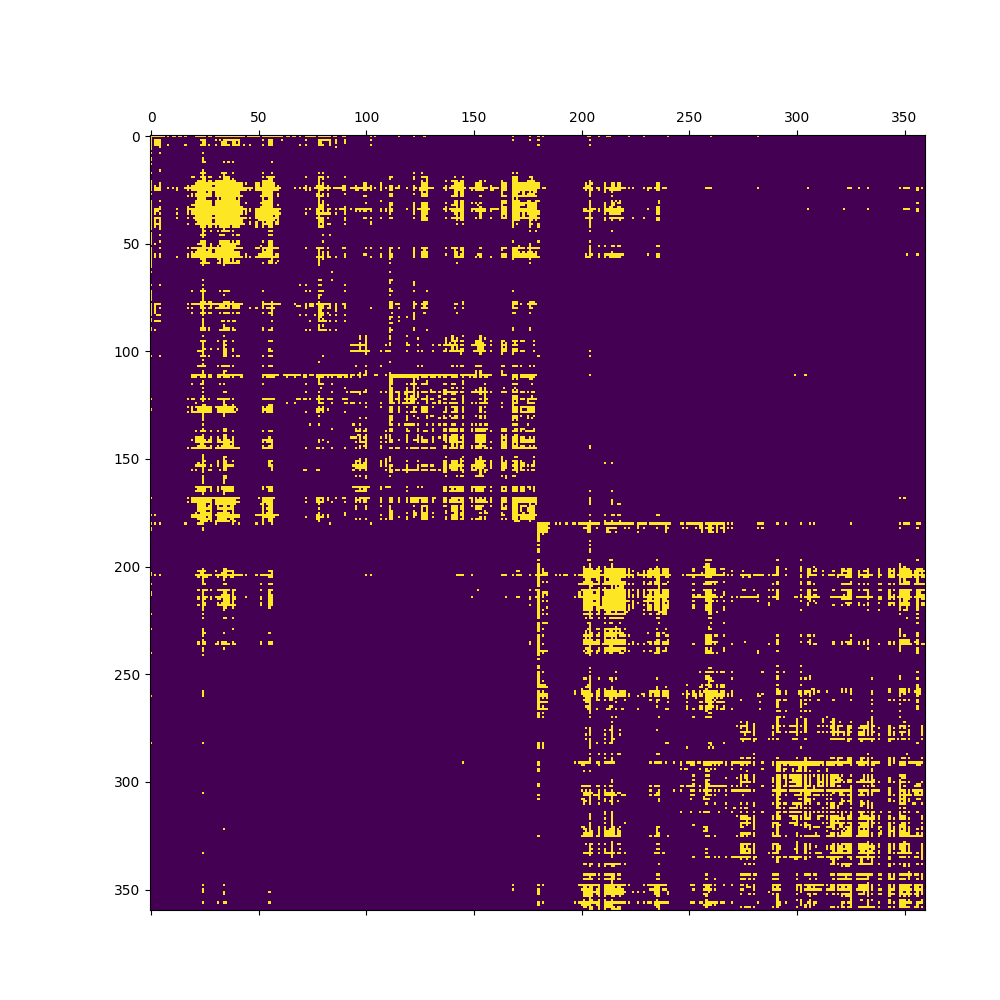

In [61]:
n_stim = np.loadtxt(f'../data/external/F-TRACT/{parcellation}/N_stimulations.txt.gz')
plt.matshow(n_stim>100, interpolation='none')

In [62]:
import numpy.ma as ma
def masked_correlation(A,B):
    return ma.corrcoef(ma.masked_invalid(A),ma.masked_invalid(B))



mask = n_stim>100
np.fill_diagonal(mask, False)

mask_amp = mask # (n_stim*response_probability)>100 # 100 significant responses... right? FIXME tohle je hodně podezřelé

In [63]:
PLOT = False

In [64]:
# shortcut for correlation of X with response probability and amplitude 
rpf = response_probability[mask].flatten()
raf = response_amplitude[mask_amp].flatten()

def coor_with_response(X):
    r_probability = spearmanr(X[mask].flatten(),rpf,nan_policy='omit')
    r_amplitude = spearmanr(X[mask_amp].flatten(),raf,nan_policy='omit')

    print(f"Correlation with response probabilty: {r_probability.statistic:.3f} (p={r_probability.pvalue:.3f})")
    print(f"Correlation with response amplitude: {r_amplitude.statistic:.3f} (p={r_amplitude.pvalue:.3f})")

    if PLOT:
        coor_plot(X)

def coor_plot(X):
    rpf_ranks = rankdata(rpf[~np.isnan(rpf)], method='ordinal')
    X_ranks_rpf = rankdata(X.flatten()[~np.isnan(rpf)], method='ordinal')
    df_rpf = pd.DataFrame({'x':X_ranks_rpf,'y':rpf_ranks})
    sns.lmplot(data=df_rpf,x='x',y='y');

    raf_ranks = rankdata(raf[~np.isnan(raf)], method='ordinal')
    X_ranks_raf = rankdata(X.flatten()[~np.isnan(raf)], method='ordinal')
    df_raf = pd.DataFrame({'x':X_ranks_raf,'y':raf_ranks})
    sns.lmplot(data=df_raf,x='x',y='y');

In [65]:
coor_with_response(W) 

Correlation with response probabilty: 0.467 (p=0.000)
Correlation with response amplitude: 0.420 (p=0.000)


In [66]:
coor_with_response(L) 

Correlation with response probabilty: -0.467 (p=0.000)
Correlation with response amplitude: -0.420 (p=0.000)


In [67]:
# shortest path efficiency
shorest_paths,_ = metrics.distance_wei_floyd(L)
shorest_path_eff = np.divide(1,shorest_paths)

if PLOT:
    plt.matshow(shorest_path_eff)

coor_with_response(shorest_path_eff)

/tmp/ipykernel_15116/2515200096.py:3: RuntimeWarning: divide by zero encountered in divide
  shorest_path_eff = np.divide(1,shorest_paths)


Correlation with response probabilty: 0.550 (p=0.000)
Correlation with response amplitude: 0.459 (p=0.000)


In [68]:
com = metrics.communicability_wei(W)

coor_with_response(com)

Correlation with response probabilty: 0.576 (p=0.000)
Correlation with response amplitude: 0.475 (p=0.000)


In [69]:
SI = metrics.search_information(W,L)

if PLOT:
    plt.matshow(SI)

coor_with_response(SI)

Correlation with response probabilty: -0.643 (p=0.000)
Correlation with response amplitude: -0.504 (p=0.000)


In [70]:
# https://netneurolab.github.io/netneurotools/_modules/netneurotools/metrics.html#diffusion_efficiency
diffusion = metrics.diffusion_efficiency(W)[1] # tahle funkce určitě má dostat SC, a ne délky L

if PLOT:
    plt.matshow(diffusion)

coor_with_response(diffusion)

Correlation with response probabilty: -0.036 (p=0.000)
Correlation with response amplitude: 0.062 (p=0.000)


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:780: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


In [71]:
# tady té funkci možná dávám špatný vstup?
_,_,nav_paths,_,_ = metrics.navigation_wu(L, W)
nav_eff = np.divide(1,nav_paths)

if PLOT:
    plt.matshow(nav_eff)

coor_with_response(nav_eff)

/tmp/ipykernel_15116/2427672740.py:3: RuntimeWarning: divide by zero encountered in divide
  nav_eff = np.divide(1,nav_paths)


Correlation with response probabilty: 0.467 (p=0.000)
Correlation with response amplitude: 0.420 (p=0.000)
